# Control Action

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
       This tutorial demonstrate how user can interact with the <code>Control</code> module in the framework by to creating a custom control. The custom control can be used with <code>ControlSequence</code> in a similar manner as the controls in <code>predefined</code> module.
    </p>
</div>


<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
       This tutorial use <code>v2</code> version of the control API. However, the key philosophy remains the same.
    </p>
</div>

Let first import the goodies

In [ ]:
import jax
import jax.numpy as jnp
import inspeqtor as sq

First of all, to provide the composability of the control, the framework model the control function $h(\Theta, t)$ using the following mathematical model,
$$
    h: (\mathbb{R}^n \times \mathbb{R}) \rightarrow \mathbb{R}.
$$
The control function is a Real scalar-valued function of a real vector of $n$ elements $\Theta$ and the scalar $t$. The vector $\Theta$ is a vector of control parameter and the scalar $t$ is a time. 

To also handle the serialization and deserialization, we use `dataclass` as a wrapper to the control function. With the additional benefit of neatly combine all we need in the instance of the object. User has to define the control by inheriting the `BaseControl`. The base class will help user define all of the necessary methodd and attribute needed, either via type hinting or raising errors.

The following are required:
* `durarion` attribute: This attributre should be an integer indicate a total time of the control $T$. Note that this is the same quantity that should be provided to the `ControlSequence` class at initialization
* `get_bounds` method: This method expect to return a tuple of lower and upper bound of flat dict of control parameter. In this case, the flat dict explicitly mean `dict[str, float]`.
* `get_envelope` method: This is the method that define the control function $h(\Theta, t)$. However, the important note is that, this function is a higher level function of the control parameter $\Theta$ that return a lower level function of time $t$. Note that this API may change in the future to reflect the mathmematical model above. 

Below is an example of how to define a custom control from scratch. The control function is define as,
$$
h((A, D), t) = \begin{cases}
    A & \text{if } (T - D)/2 < t < (T + D)/2 \\ % & is your "\tab"-like command (it's a tab alignment character)
   0 & \text{otherwise.}
\end{cases}
$$


In [44]:
from dataclasses import dataclass

@dataclass
class SquareControl(sq.experimental.control.BaseControl):
    min_duration: float
    max_duration: float
    min_ampitude: float
    max_amplitude: float
    duration: int

    def __post_init__(self):
        self.center = self.duration // 2
        super().__post_init__()


    def get_bounds(
        self,
    ) -> tuple[sq.ctyping.ParametersDictType, sq.ctyping.ParametersDictType]:
        return {"duration": self.min_duration, "amp": self.min_ampitude}, {
            "duration": self.max_duration,
            "amp": self.max_amplitude,
        }

    def get_envelope(self, params: sq.ctyping.ParametersDictType):
        # This function expect to recieve the structured control parameter.
        offset = params["duration"] / 2

        def envelope(t):
            condlist = [self.center - offset > t, t > self.center + offset]
            funclist = [0., 0., params["amp"]]

            return jnp.piecewise(t, condlist, funclist)

        return envelope

The defined control can then use in the same manner as the `predefined` one. You can also mix the predefined controls and the customs controls as expected. 

In [ ]:
from flax.nnx import display

total_dt = 100

square_ctrl = SquareControl(
    min_duration=10.0,
    max_duration=50.0,
    min_ampitude=0.0,
    max_amplitude=1.0,
    duration=total_dt,
)

control_sequence = sq.control.ControlSequence(
    controls={"sqaure": square_ctrl},
    total_dt=total_dt,
)

key = jax.random.key(0)
param = control_sequence.sample_params(key)

display(param), display(control_sequence)

(None, None)

Let us visualize the sample of the control using built-in function. This function plot both real and imaginary component of the control. Note that this is a design that heavily based on the superconducting qubit platform. However, the concept can easily extented to other platforms too.

(0.0, 1.0)

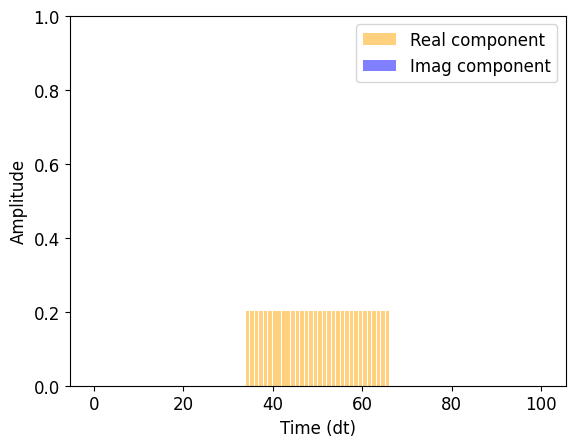

In [35]:
import matplotlib.pyplot as plt

t_eval = jnp.linspace(0, total_dt, 100)
waveform = control_sequence.get_envelope(param)(t_eval)
fig, ax = plt.subplots()
sq.visualization.plot_control_envelope(waveform, t_eval, ax)
ax.set_ylim(0, 1)

Similarly, we handle the serialization/deserialization for you.

In [48]:
import tempfile
from pathlib import Path

from inspeqtor.v2.control import construct_control_sequence_reader

with tempfile.TemporaryDirectory() as temp:
    path = Path(temp)
    # Create the path with parents if not existed already
    path.mkdir(parents=True, exist_ok=True)
    
    control_sequence.to_file(path)

    # Load it back
    control_reader = construct_control_sequence_reader(controls=[SquareControl])
    reread_control_seq = control_reader(path)

    print(reread_control_seq)

assert reread_control_seq == control_sequence

display(reread_control_seq)

ControlSequence(controls={'sqaure': SquareControl(duration=100, min_duration=10.0, max_duration=50.0, min_ampitude=0.0, max_amplitude=1.0)}, total_dt=100, structure=[('sqaure', 'duration'), ('sqaure', 'amp')])
